<a href="https://colab.research.google.com/github/eshal26/Leukemia-classification/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip Original.zip

Archive:  Original.zip
   creating: Original/Benign/
  inflating: Original/Benign/WBC-Benign-001.jpg  
  inflating: Original/Benign/WBC-Benign-002.jpg  
  inflating: Original/Benign/WBC-Benign-003.jpg  
  inflating: Original/Benign/WBC-Benign-004.jpg  
  inflating: Original/Benign/WBC-Benign-005.jpg  
  inflating: Original/Benign/WBC-Benign-006.jpg  
  inflating: Original/Benign/WBC-Benign-007.jpg  
  inflating: Original/Benign/WBC-Benign-008.jpg  
  inflating: Original/Benign/WBC-Benign-009.jpg  
  inflating: Original/Benign/WBC-Benign-010.jpg  
  inflating: Original/Benign/WBC-Benign-011.jpg  
  inflating: Original/Benign/WBC-Benign-012.jpg  
  inflating: Original/Benign/WBC-Benign-013.jpg  
  inflating: Original/Benign/WBC-Benign-014.jpg  
  inflating: Original/Benign/WBC-Benign-015.jpg  
  inflating: Original/Benign/WBC-Benign-016.jpg  
  inflating: Original/Benign/WBC-Benign-017.jpg  
  inflating: Original/Benign/WBC-Benign-018.jpg  
  inflating: Original/Benign/WBC-Benign-019.jpg

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import os
import sklearn
from sklearn.model_selection import train_test_split

In [3]:

import shutil

# Define paths to your dataset directories
dataset_dir = 'Original'
benign_dir = os.path.join(dataset_dir, 'Benign')
malignant_dir = os.path.join(dataset_dir, 'Malignant')  # Create this directory if it doesn't exist

# Create the malignant directory if it doesn't exist
if not os.path.exists(malignant_dir):
    os.makedirs(malignant_dir)

# Move images from early, pre, and pro directories to malignant directory
for stage in ['Early', 'Pre', 'Pro']:
    stage_dir = os.path.join(dataset_dir, stage)
    for img_file in os.listdir(stage_dir):
        img_path = os.path.join(stage_dir, img_file)
        shutil.move(img_path, malignant_dir)

# Update dataset directory structure and labels
os.rmdir(os.path.join(dataset_dir, 'Early'))
os.rmdir(os.path.join(dataset_dir, 'Pre'))
os.rmdir(os.path.join(dataset_dir, 'Pro'))


In [4]:

from sklearn.model_selection import train_test_split

# Define paths to your original dataset directory
original_data_dir = 'Original'
benign_dir = os.path.join(original_data_dir, 'Benign')
malignant_dir = os.path.join(original_data_dir, 'Malignant')

# Define paths to create directories for the new dataset splits
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Create directories for the new dataset splits if they don't exist
for directory in [train_dir, val_dir, test_dir]:
    os.makedirs(directory, exist_ok=True)
    for category in ['Benign', 'Malignant']:
        os.makedirs(os.path.join(directory, category), exist_ok=True)

# Split dataset and copy images to appropriate directories
for category_dir, category in [(benign_dir, 'Benign'), (malignant_dir, 'Malignant')]:
    image_files = [os.path.join(category_dir, img) for img in os.listdir(category_dir)]
    train_files, test_val_files = train_test_split(image_files, test_size=0.2, random_state=42)
    val_files, test_files = train_test_split(test_val_files, test_size=0.5, random_state=42)

    for file in train_files:
        shutil.copy(file, os.path.join(train_dir, category))
    for file in val_files:
        shutil.copy(file, os.path.join(val_dir, category))
    for file in test_files:
        shutil.copy(file, os.path.join(test_dir, category))


In [5]:

from torch.utils.data import DataLoader

# Define paths to your dataset directories
train_dir = 'train_dataset'
val_dir = 'validation_dataset'
test_dir = 'test_dataset'

# Define transformations for training, validation, and testing data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=val_test_transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=val_test_transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define the pre-trained ResNet-50 model
model = torchvision.models.resnet50(pretrained=True)

# Freeze parameters of the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

# Modify the final fully connected layer for binary classification
num_features = model.fc.in_features
model.fc = torch.nn.Linear(num_features, 2)  # Binary classification with 2 output units

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)




/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [6]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Initialize lists to store metrics
train_acc_history = []
val_acc_history = []
train_precision_history = []
val_precision_history = []
train_recall_history = []
val_recall_history = []
train_f1_history = []
val_f1_history = []

num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    all_train_labels = []
    all_train_preds = []
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)

        _, predicted = torch.max(outputs, 1)
        all_train_labels.extend(labels.cpu().numpy())
        all_train_preds.extend(predicted.cpu().numpy())

    epoch_loss = running_loss / len(train_loader.dataset)
    train_accuracy = sum(np.array(all_train_preds) == np.array(all_train_labels)) / len(all_train_labels)
    train_precision = precision_score(all_train_labels, all_train_preds, average='weighted')
    train_recall = recall_score(all_train_labels, all_train_preds, average='weighted')
    train_f1 = f1_score(all_train_labels, all_train_preds, average='weighted')

    train_acc_history.append(train_accuracy)
    train_precision_history.append(train_precision)
    train_recall_history.append(train_recall)
    train_f1_history.append(train_f1)

    print(f"Epoch {epoch + 1}, Training Loss: {epoch_loss:.4f}, Accuracy: {train_accuracy:.4f}, Precision: {train_precision:.4f}, Recall: {train_recall:.4f}, F1-score: {train_f1:.4f}")

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    all_val_labels = []
    all_val_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_val_labels.extend(labels.cpu().numpy())
            all_val_preds.extend(predicted.cpu().numpy())

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct / total
    val_precision = precision_score(all_val_labels, all_val_preds, average='weighted')
    val_recall = recall_score(all_val_labels, all_val_preds, average='weighted')
    val_f1 = f1_score(all_val_labels, all_val_preds, average='weighted')

    val_acc_history.append(val_accuracy)
    val_precision_history.append(val_precision)
    val_recall_history.append(val_recall)
    val_f1_history.append(val_f1)

    print(f"Epoch {epoch + 1}, Validation Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1-score: {val_f1:.4f}")


Epoch 1, Training Loss: 0.2777, Accuracy: 0.8917, Precision: 0.8820, Recall: 0.8917, F1-score: 0.8802
Epoch 1, Validation Loss: 0.1371, Accuracy: 0.9723, Precision: 0.9742, Recall: 0.9723, F1-score: 0.9728
Epoch 2, Training Loss: 0.1077, Accuracy: 0.9700, Precision: 0.9696, Recall: 0.9700, F1-score: 0.9695
Epoch 2, Validation Loss: 0.0891, Accuracy: 0.9692, Precision: 0.9689, Recall: 0.9692, F1-score: 0.9690
Epoch 3, Training Loss: 0.0721, Accuracy: 0.9816, Precision: 0.9814, Recall: 0.9816, F1-score: 0.9813
Epoch 3, Validation Loss: 0.0761, Accuracy: 0.9723, Precision: 0.9733, Recall: 0.9723, F1-score: 0.9726
Epoch 4, Training Loss: 0.0655, Accuracy: 0.9789, Precision: 0.9787, Recall: 0.9789, F1-score: 0.9787
Epoch 4, Validation Loss: 0.0665, Accuracy: 0.9785, Precision: 0.9793, Recall: 0.9785, F1-score: 0.9787
Epoch 5, Training Loss: 0.0529, Accuracy: 0.9846, Precision: 0.9845, Recall: 0.9846, F1-score: 0.9845
Epoch 5, Validation Loss: 0.0703, Accuracy: 0.9785, Precision: 0.9801, Rec

In [7]:
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    return test_loss, accuracy, precision, recall, f1

# Evaluate the model on the test set
test_loss, test_accuracy, test_precision, test_recall, test_f1 = evaluate_model(model, test_loader, criterion, device)


Test Accuracy: 0.9908
Test Precision: 0.9909
Test Recall: 0.9908
Test F1-score: 0.9907


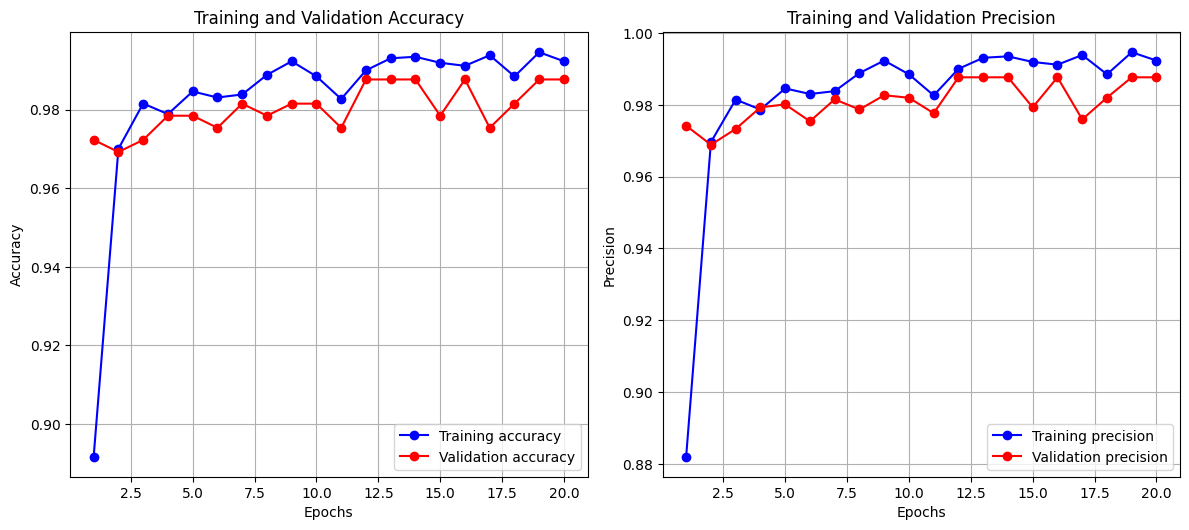

In [8]:
import matplotlib.pyplot as plt

def plot_metrics(train_acc_history, val_acc_history, train_precision_history, val_precision_history):
    epochs = range(1, len(train_acc_history) + 1)

    plt.figure(figsize=(12, 10))

    # Plot accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_acc_history, 'bo-', label='Training accuracy')
    plt.plot(epochs, val_acc_history, 'ro-', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    # Plot precision
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_precision_history, 'bo-', label='Training precision')
    plt.plot(epochs, val_precision_history, 'ro-', label='Validation precision')
    plt.title('Training and Validation Precision')
    plt.xlabel('Epochs')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()




    plt.tight_layout()
    plt.show()

# Plot the metrics
plot_metrics(train_acc_history, val_acc_history, train_precision_history, val_precision_history)


Test Loss: 0.0234
Test Accuracy: 0.9908
Test Precision: 0.9909
Test Recall: 0.9908
Test F1-score: 0.9907
Confusion Matrix:
 [[ 48   3]
 [  0 276]]


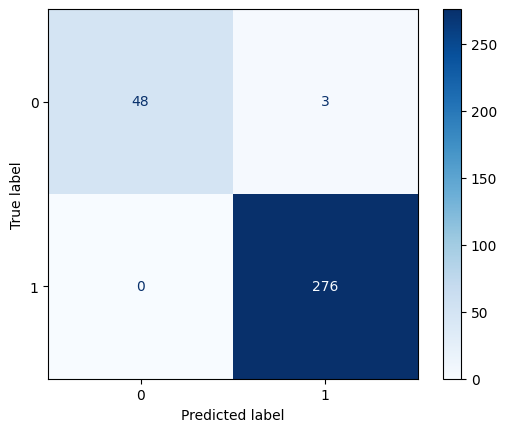

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.94      0.97        51
           1       0.99      1.00      0.99       276

    accuracy                           0.99       327
   macro avg       0.99      0.97      0.98       327
weighted avg       0.99      0.99      0.99       327



In [9]:

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def evaluate_model_with_detailed_metrics(model, dataloader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())

    test_loss /= len(dataloader.dataset)
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')

    print(f'Test Loss: {test_loss:.4f}')
    print(f'Test Accuracy: {accuracy:.4f}')
    print(f'Test Precision: {precision:.4f}')
    print(f'Test Recall: {recall:.4f}')
    print(f'Test F1-score: {f1:.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:\n", cm)

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

    # Print classification report
    class_report = classification_report(all_labels, all_preds)
    print("Classification Report:\n", class_report)

    return test_loss, accuracy, precision, recall, f1, cm, class_report

test_loss, test_accuracy, test_precision, test_recall, test_f1, cm, class_report = evaluate_model_with_detailed_metrics(model, test_loader, criterion, device)

